In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats
from collections import defaultdict

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import re
from gseapy import Biomart

import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

In [98]:
import palettable
Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# Analyze Gene Set Enrichment Results

My previous notebook, where I generated the results for the gene set enrichment results (`cwas-gene-set-enrichment`), was getting way too long. I'll use this notebook to analyze the results instead.

There are a _ton_ of results here. We'll need to be careful in parsing through these.

# Load in our data

We have to load in all our appropriate data, including SVs and the gene set enrichment results. We copy the same process as detailed in `cwas-gene-set-enrichment`

In [2]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

Load metadata and SVs

In [3]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
nbl_cases = metadata[
    (metadata["neuroblastoma_case"] == True)
]["entity:sample_id"].tolist()

nbl_controls = metadata[
    (metadata["neuroblastoma_control"] == True)
]["entity:sample_id"].tolist()

len(nbl_cases), len(nbl_controls)

(688, 4831)

Now we load the SVs. We'll eventually combine discovery and validation data, but it's easiest to keep them separate for now, since the SVs and dosages are not fully overlapping.

In [4]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
)

###############
### Dosages ###
###############
dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
dosages = dosages.iloc[:, 3:].set_index('ID')

## Read in category genes

These are the genes that are eligible for each category.

In [6]:
category_gene_matrix = pd.read_csv('data/cwas-results/category-gene-matrix.csv').set_index('category')

In [7]:
category_gene_matrix.iloc[:10, :50]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS1,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,ABCB4,ABCB5,ABCB6,ABCB7,ABCB8
category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
DEL.SINGLETON.ANY.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ANY.SINGLETON.ANY.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1


In [8]:
gene_ref = list(category_gene_matrix.columns)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [9]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [10]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [11]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [12]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

In [210]:
nbl_coding_framework

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs
3,INS_ALL,NaN,ANY,ANY,NaN,base_excision_repair_genes
4,ANY,NaN,NaN,NaN,NaN,chromatin_organization_genes
5,NaN,NaN,NaN,NaN,NaN,dna_damage_bypass_genes
6,NaN,NaN,NaN,NaN,NaN,dna_damage_reversal_genes
7,NaN,NaN,NaN,NaN,NaN,dna_DSB_repair_genes
8,NaN,NaN,NaN,NaN,NaN,dna_DSB_response_genes
9,NaN,NaN,NaN,NaN,NaN,dna_repair_genes


In [13]:
nbl_noncoding_framework

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,neuroblastoma_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,neuroblastoma_ABC_MAX_enhancer,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,neuroblastoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,neuroblastoma_chromHMM15_EnhBiv,NaN,NaN,NaN,NaN


## Shrink down our data

We subset some of our data to prevent working with massive matrices.

In [14]:
# shrink down our categories to only those that are significant
nbl_framework_results = nbl_framework_results.query('negative_log10_p_value > 3.5').reset_index(drop = True)

# subset down category svs to these categories
nbl_category_svs = nbl_category_svs[nbl_category_svs['category'].isin(nbl_framework_results['category_name'].tolist())].reset_index(drop = True)

# drop SVs down to these SVs
svs = svs[svs['name'].isin(set(nbl_category_svs['SV']))]

# shrink dosages down to our nbl samples and these SVs
dosages = dosages.loc[svs['name'].tolist(), nbl_cases + nbl_controls]

# shrink down category lookups
category_gene_matrix = category_gene_matrix.loc[nbl_framework_results['category_name'].tolist()]

## Read in gene set enrichment results

Read in our GSE results for the categories. This file is _huge_, since we fully enumerated a number of possible analyses.

In [15]:
category_sv_gse_gene_lists = pd.read_csv('data/cwas-results/gene-set-enrichment-analysis-counts.csv')
category_sv_gse_results = pd.read_csv('data/cwas-results/cwas-gene-set-enrichment-results.csv')

In [16]:
category_sv_gse_results.head(2)

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,multiple,none,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,2,199/19092,2/543,0.34507,0.13379,1.0,14,199/19092,14/3308,0.37073,0.00008,0.00199,2,185/16470,2/374,0.46795,0.44976,1.0
1,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,multiple,none,MSigDB_Hallmark_2020,Hypoxia,4,200/19092,5/543,0.87195,1.00000,1.0,21,200/19092,25/3308,0.68675,0.08987,0.28085,4,179/16470,5/374,1.23391,0.60890,1.0


In [224]:
category_to_expression = {c: c.split('.')[4] if len(c.split('.')) == 6 else c.split('.')[6] for c in nbl_framework_results['category_name'].tolist()}
category_sv_gse_results['expression'] = [category_to_expression[c] for c in category_sv_gse_results['category'].tolist()]

category_to_functional = {c: c.split('.')[3] if len(c.split('.')) == 8 else np.nan for c in nbl_framework_results['category_name'].tolist()}
category_sv_gse_results['functional_category'] = [category_to_functional[c] for c in category_sv_gse_results['category'].tolist()]

Now we read in the gene sets

In [225]:
gene_sets = {}
with open('ref/gene-sets.txt') as gs_in:
    for line in gs_in:
        comp = line.strip().split('\t')
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]
        gene_sets[db + ' | ' + gs] = genes

Finally, we read in the _category_ gene set enrichment results. This is the gene set enrichment that is intrinsic to the categories themselves.

In [226]:
category_baseline_gse_results = pd.read_csv('data/cwas-results/category-gene-set-raw-significance.csv')[['category', 'db', 'gs', 'expected', 'data', 'odds_ratio', 'p', 'fdr_p']]

In [227]:
analyzed_categories = nbl_framework_results['category_name'].tolist()
category_baseline_gse_results = category_baseline_gse_results[category_baseline_gse_results['category'].isin(analyzed_categories)]
category_baseline_gse_results = category_baseline_gse_results.merge(nbl_framework_results[['category_name', 'sv_category']], left_on = ['category'], right_on = ['category_name'])

In [228]:
category_baseline_gse_results['-logq'] = -np.log10(category_baseline_gse_results['fdr_p'])
category_baseline_gse_results['log-odds'] = np.log(category_baseline_gse_results['odds_ratio'])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [229]:
category_baseline_gse_results.head(2)

,category,db,gs,expected,data,odds_ratio,p,fdr_p,category_name,sv_category,-logq,log-odds
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,199/19092,199/19092,NaN,1.0,1.0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,-0.0,NaN
1,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,MSigDB_Hallmark_2020,Hypoxia,200/19092,200/19092,NaN,1.0,1.0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,-0.0,NaN


# Analyze high level category results

To start, we'll examine the category baseline results alone.

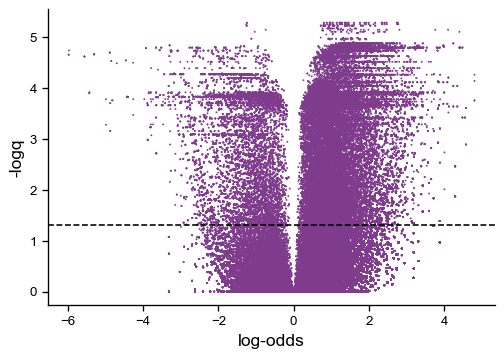

In [230]:
fig, ax = plt.subplots(1, figsize = (6, 4))
sns.scatterplot(x = 'log-odds', y = '-logq', data = category_baseline_gse_results, ec = None, s = 2)
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
fig.savefig('images/baseline-category-enrichment-all.png', bbox_inches = 'tight')

In [231]:
neuroblastoma_tad_categories = [c for c in analyzed_categories if '.neuroblastoma_tad_boundary.' in c]
neuroblastoma_tad_results = category_baseline_gse_results[(category_baseline_gse_results['category'].isin(neuroblastoma_tad_categories))]
neurogenesis_tad = neuroblastoma_tad_results[neuroblastoma_tad_results['gs'] == "neurogenesis (GO:0022008)"].sort_values(by = 'fdr_p')

In [232]:
neurogenesis_tad['adrenal'] = neurogenesis_tad['category'].str.contains('adrenal')

In [233]:
neurogenesis_tad.query('db == "GO_Biological_Process_Specific" & fdr_p < 0.05').iloc[0, 0]

'DUP.RARE.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.lof_constrained.ANY.protein_coding'

## GO Full vs. GO Specific

In [234]:
go_full = category_baseline_gse_results.query('db == "GO_Biological_Process_Full"')
go_specific = category_baseline_gse_results.query('db == "GO_Biological_Process_Specific"')

In [235]:
go_specific.shape

(966966, 12)

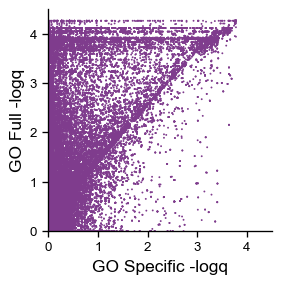

In [236]:
fig, ax = plt.subplots(1, figsize = (3, 3))
sns.scatterplot(x = go_specific['-logq'].values, y = go_full['-logq'].values, s = 2, ec = None)
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 4.5])
sns.despine(ax = ax)
ax.set_xlabel('GO Specific -logq')
ax.set_ylabel('GO Full -logq')
fig.savefig('images/go-full-vs-specific.png', bbox_inches = 'tight')

## Compare the category subsetting to no subsetting

Let's just find an example

In [237]:
test = category_sv_gse_results.query('sv_category == "non-coding" & sv_incl_strat == "single" & gene_subset == "none" & unique_gene_overlaps_cases_unique > 1 & db == "MSigDB_Hallmark_2020"').sort_values(by = 'fdr_p_cases_unique')
test = test[~test['category'].str.contains('conserved')]
test_cat = test.iloc[0, 0]
test.iloc[0]

category                             DEL.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...
sv_category                                                                 non-coding
sv_incl_strat                                                                   single
gene_subset                                                                       none
db                                                                MSigDB_Hallmark_2020
gs                                                             Estrogen Response Early
unique_gene_overlaps_cases                                                          12
expected_cases                                                               197/19092
data_cases                                                                      12/236
odds_ratio_cases                                                               5.41129
p_cases                                                                        0.00001
fdr_p_cases                                

In [238]:
category_baseline_gse_results.query(f'category == "{test_cat}" & gs == "Estrogen Response Early"')

,category,db,gs,expected,data,odds_ratio,p,fdr_p,category_name,sv_category,-logq,log-odds
1025366,DEL.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,MSigDB_Hallmark_2020,Estrogen Response Early,197/19092,176/15043,2.270699,0.000145,0.000661,DEL.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,non-coding,3.179572,0.820088


In [239]:
category_sv_gse_results.query(f'category == "{test_cat}" & sv_incl_strat == "single" & gene_subset == "category_subset" & gs == "Estrogen Response Early"')

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category
4182377,DEL.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,non-coding,single,category_subset,MSigDB_Hallmark_2020,Estrogen Response Early,12,176/15043,12/236,4.78844,0.00002,0.00108,20,176/15043,37/1341,2.51767,0.00001,0.0001,10,158/14066,10/162,6.11931,0.00001,0.00072,ANY,neuroblastoma_chromHMM15_Enh


## Plot the differences

In [240]:
plot_data = category_sv_gse_results.query('sv_incl_strat == "single"')
plot_data_none = plot_data.query('gene_subset == "none"')
plot_data_category_subset = plot_data.query('gene_subset == "category_subset"')

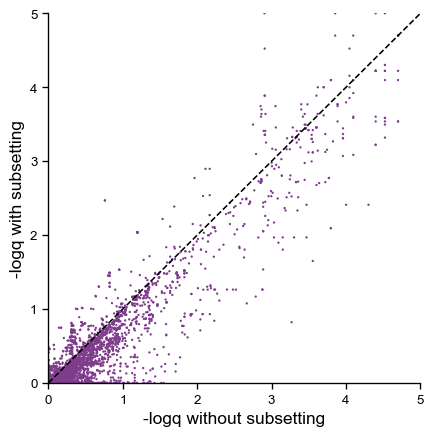

In [241]:
fig, ax = plt.subplots(1, figsize = (5, 5))
sns.scatterplot(x = -np.log10(plot_data_none['fdr_p_cases_unique']).values, y = -np.log10(plot_data_category_subset['fdr_p_cases_unique']).values,
                ec = None, s = 3)
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.plot([0, 5], [0, 5], linestyle = 'dashed', color = 'black')
ax.set_xlabel('-logq without subsetting')
ax.set_ylabel('-logq with subsetting')
sns.despine(ax = ax)
fig.savefig('images/subsetting-vs-not-q-cwas-gene-set-enrichment.png', bbox_inches = 'tight')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


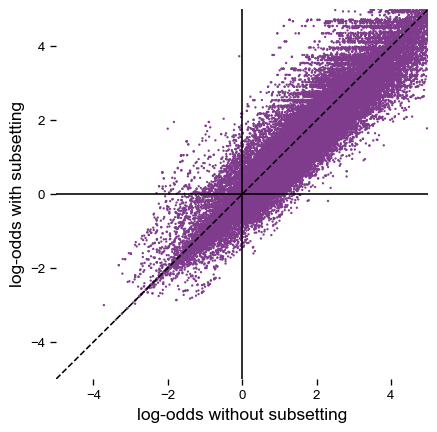

In [242]:
fig, ax = plt.subplots(1, figsize = (5, 5))
sns.scatterplot(x = np.log2(plot_data_none['odds_ratio_cases_unique']).values, y = np.log2(plot_data_category_subset['odds_ratio_cases_unique']).values,
                ec = None, s = 3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.plot([-5, 5], [-5, 5], linestyle = 'dashed', color = 'black')
ax.set_xlabel('log-odds without subsetting')
ax.set_ylabel('log-odds with subsetting')
sns.despine(ax = ax, bottom = True, left = True)
ax.axvline(x = 0, color = 'black')
ax.axhline(y = 0, color = 'black')
fig.savefig('images/subsetting-vs-not-odds-ratio-cwas-gene-set-enrichment.png', bbox_inches = 'tight')

In [243]:
test = pd.DataFrame()
test['without-subsetting'] = np.abs(np.log2(plot_data_none['odds_ratio_cases_unique']).values)
test['with-subsetting'] = np.abs(np.log2(plot_data_category_subset['odds_ratio_cases_unique']).values)

test = test[test['without-subsetting'] != test['with-subsetting']]
test = test.dropna(how = 'any')
test = test[(test['without-subsetting'] + test['with-subsetting']) != np.inf]
# pd.DataFrame([np.log2(plot_data_none['odds_ratio_cases_unique']).values, np.log2(plot_data_category_subset['odds_ratio_cases_unique']).values])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [244]:
(test['without-subsetting'] > test['with-subsetting']).mean()

0.66814800706811

## Examine category baseline vs. subsetting

In [245]:
plot_data_category_subset.head(2)

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category
80949,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,single,category_subset,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,2,199/19092,2/371,0.51045,0.59841,0.99773,6,199/19092,6/2114,0.25223,0.00008,0.00389,2,193/17386,2/267,0.66949,1.00000,1.0,ANY,NaN
80950,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,single,category_subset,MSigDB_Hallmark_2020,Hypoxia,3,200/19092,4/371,1.02646,0.79818,0.99773,13,200/19092,15/2114,0.65383,0.13854,0.45428,3,187/17386,4/267,1.40106,0.53965,1.0,ANY,NaN


In [246]:
joint_data = plot_data_category_subset.merge(category_baseline_gse_results[['category', 'db', 'gs', 'fdr_p']]).rename(columns = {'fdr_p': 'category_baseline_fdr_p'})
joint_data['color'] = np.where(plot_data_none['fdr_p_cases_unique'] < 0.05, 'significant w/ naive counts', 'not significant w/ naive counts')

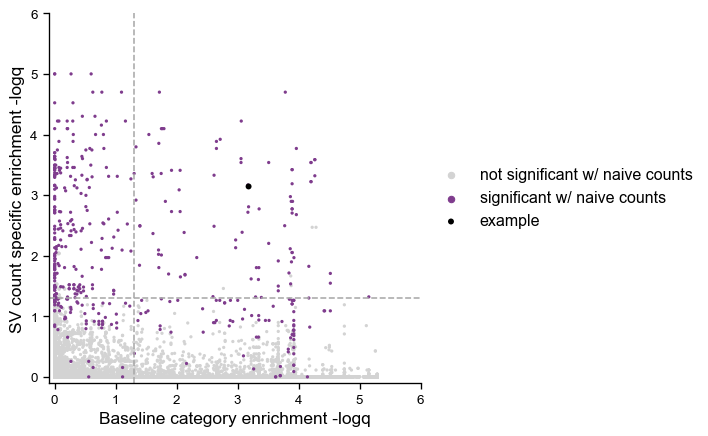

In [247]:
fig, ax = plt.subplots(1, figsize = (5, 5))

palette = {'not significant w/ naive counts': 'lightgrey', 'significant w/ naive counts': Bold_10[0]}
for color in ['not significant w/ naive counts', 'significant w/ naive counts']:
    plot_data = joint_data[joint_data['color'] == color]
    zorder = 0 if 'not' in label else 1

    sns.scatterplot(x = -np.log10(plot_data['category_baseline_fdr_p']), y = -np.log10(plot_data['fdr_p_cases_unique']),
                    ax = ax, s = 6, ec = None, hue = joint_data['color'], palette = palette, zorder = zorder)
    
# sns.scatterplot(x = -np.log10(joint_data['category_baseline_fdr_p']), y = -np.log10(joint_data['fdr_p_cases_unique']),
#                 s = 4, ec = None, hue = joint_data['color'], palette = {'not significant w/ naive counts': 'lightgrey', 'significant w/ naive counts': Bold_10[0]})
# test_point = joint_data.query(f'category == "{test_cat}" & gs == "Estrogen Response Early"')
sns.scatterplot(x = -np.log10(test_point['category_baseline_fdr_p']), y = -np.log10(test_point['fdr_p_cases_unique']),
                s = 20, color = 'black', ec = None, label = 'example')
ax.set_xlim([-0.1, 6])
ax.set_ylim([-0.1, 6])
ax.set_xlabel('Baseline category enrichment -logq')
ax.set_ylabel('SV count specific enrichment -logq')
ax.axvline(x = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')
ax.axhline(y = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')

handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[4]]
labels = [labels[0], labels[1], labels[4]]
ax.legend(handles, labels, bbox_to_anchor = (1, 0.5))
sns.despine()

fig.savefig('images/separating-influences-cwas-gene-set-enrichment.png', bbox_inches = 'tight')

In [248]:
tad_joint_data = joint_data[(joint_data['category'].str.contains('\.neuroblastoma_tad_boundary\.'))]

In [249]:
tad_joint_data.shape

(458711, 28)

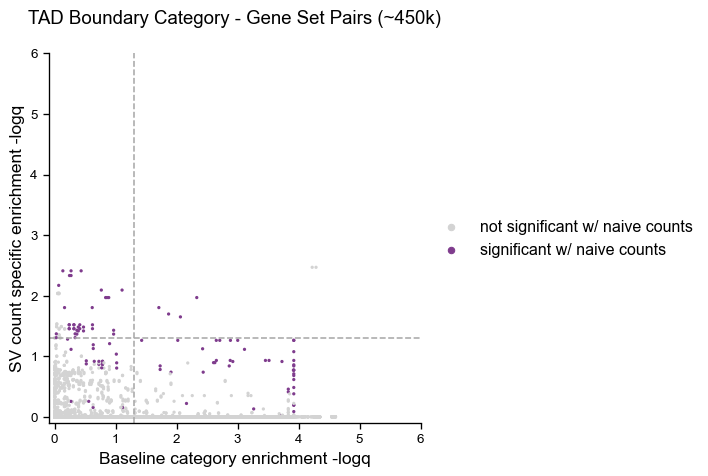

In [250]:
fig, ax = plt.subplots(1, figsize = (5, 5))

sns.scatterplot(x = -np.log10(tad_joint_data['category_baseline_fdr_p']), y = -np.log10(tad_joint_data['fdr_p_cases_unique']),
                ax = ax, s = 6, ec = None, hue = tad_joint_data['color'], palette = palette)
    
ax.set_xlim([-0.1, 6])
ax.set_ylim([-0.1, 6])
ax.set_xlabel('Baseline category enrichment -logq')
ax.set_ylabel('SV count specific enrichment -logq')
ax.axvline(x = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')
ax.axhline(y = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')

ax.legend(bbox_to_anchor = (1, 0.5))
sns.despine()

ax.set_title('TAD Boundary Category - Gene Set Pairs (~450k)', y = 1.06)
fig.savefig('images/separating-influences-cwas-gene-set-enrichment-tads.png', bbox_inches = 'tight')

# Analyze most stringent results

In [259]:
coding_categories = nbl_framework_results.query('sv_category == "coding"')['category_name'].tolist()

In [261]:
coding_categories

['ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding',
 'DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding',
 'ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding',
 'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding',
 'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding',
 'ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding',
 'DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding',
 'DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding']

In [251]:
joint_data = category_sv_gse_results.merge(category_baseline_gse_results[['category', 'db', 'gs', 'fdr_p']]).rename(columns = {'fdr_p': 'category_baseline_fdr_p'})


In [252]:
joint_data.head(2)

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category,category_baseline_fdr_p
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,multiple,none,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,2,199/19092,2/543,0.34507,0.13379,1.0,14,199/19092,14/3308,0.37073,0.00008,0.00199,2,185/16470,2/374,0.46795,0.44976,1.0,ANY,NaN,1.0
1,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,multiple,category_subset,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,2,199/19092,2/543,0.34507,0.13379,1.0,14,199/19092,14/3308,0.37073,0.00008,0.00199,2,185/16470,2/374,0.46795,0.44976,1.0,ANY,NaN,1.0


In [253]:
stringent_coding_results = joint_data[(joint_data['sv_incl_strat'] == "single") &
                                      (joint_data['gene_subset'] == "category_subset") &
                                      (joint_data['unique_gene_overlaps_cases_unique'] > 1) &
                                      (joint_data['p_controls'] > 0.05) &
                                      (joint_data['sv_category'] == "coding")]

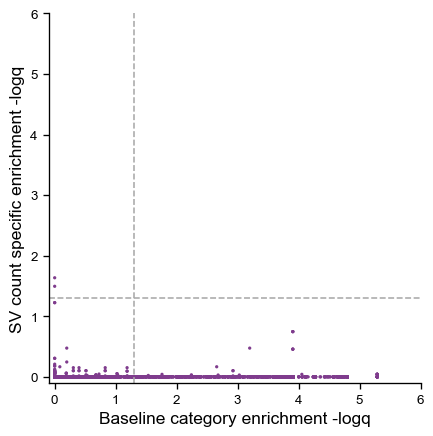

In [263]:
fig, ax = plt.subplots(1, figsize = (5, 5))

sns.scatterplot(x = -np.log10(stringent_coding_results['category_baseline_fdr_p']), y = -np.log10(stringent_coding_results['fdr_p_cases_unique']),
                ax = ax, s = 6, ec = None, zorder = zorder)

ax.set_xlim([-0.1, 6])
ax.set_ylim([-0.1, 6])
ax.set_xlabel('Baseline category enrichment -logq')
ax.set_ylabel('SV count specific enrichment -logq')
ax.axvline(x = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')
ax.axhline(y = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')

sns.despine()

fig.savefig('images/separating-influences-cwas-gene-set-enrichment-coding.png', bbox_inches = 'tight')

In [271]:
stringent_coding_results[stringent_coding_results['fdr_p_cases_unique'] < 0.05]

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category,category_baseline_fdr_p
47,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,single,category_subset,MSigDB_Hallmark_2020,Adipogenesis,11,200/19092,12/371,3.28266,0.00058,0.02908,16,200/19092,16/2114,0.70925,0.20986,0.50144,9,186/17386,10/267,3.72771,0.00064,0.03199,ANY,NaN,1.0
323843,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,single,category_subset,MSigDB_Hallmark_2020,Adipogenesis,12,200/19092,13/438,3.01001,0.00077,0.03848,19,200/19092,20/2576,0.72610,0.20762,0.54845,10,183/17093,11/304,3.60930,0.00046,0.02315,ANY,NaN,1.0


In [388]:
np.array([200/19092, 12/371, 16/2114]) * 100

array([1.04755919, 3.23450135, 0.75685904])

In [283]:
test = stringent_coding_results.query('expression == "expressed_in_adrenal_gland" & category_baseline_fdr_p < 0.05 & fdr_p_cases_unique < 1')
print(set(test['category']))
test.groupby(['gs', 'category']).size()

{'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding', 'ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding'}


gs                                                       category                                                                                               
Adipogenesis                                             ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                            1
Androgen Response                                        ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                            1
Cholesterol Homeostasis                                  ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                            1
Fatty Acid Metabolism                                    ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                            1
Glycolysis                                               ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                            1
Interfero

What about with no subsetting

In [286]:
stringent_coding_results = joint_data[(joint_data['sv_incl_strat'] == "single") &
                                      (joint_data['gene_subset'] == "none") &
                                      (joint_data['unique_gene_overlaps_cases_unique'] > 1) &
                                      (joint_data['p_controls'] > 0.05) &
                                      (joint_data['sv_category'] == "coding")]

In [292]:
stringent_coding_results.query('fdr_p_cases_unique < 0.05')

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category,category_baseline_fdr_p
46,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,single,none,MSigDB_Hallmark_2020,Adipogenesis,11,200/19092,12/371,3.28266,0.00058,0.02908,16,200/19092,16/2114,0.70925,0.20986,0.50144,9,186/17386,10/267,3.72771,0.00064,0.03199,ANY,NaN,1.0
323842,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,single,none,MSigDB_Hallmark_2020,Adipogenesis,12,200/19092,13/438,3.01001,0.00077,0.03848,19,200/19092,20/2576,0.72610,0.20762,0.54845,10,183/17093,11/304,3.60930,0.00046,0.02315,ANY,NaN,1.0


In [ ]:
sig_results = stringent_coding_results.query('fdr_p_cases_unique < 0.05 | category_baseline_fdr_p < 0.05').groupby(['db', 'gs']).size().reset_index()
stringent_coding_results.query('db == "GO_Biological_Process_Full" & fdr_p_cases_unique != 1').sort_values(by = 'category_baseline_fdr_p')

In [198]:
len(gene_sets['GO_Biological_Process_Full | developmental process involved in reproduction (GO:0003006)'])

968

# Analyze the most stringent results - non-coding

In [293]:
stringent_noncoding_results = joint_data[(joint_data['sv_incl_strat'] == "single") &
                                      (joint_data['gene_subset'] == "category_subset") &
                                      (joint_data['unique_gene_overlaps_cases_unique'] > 1) &
                                      (joint_data['p_controls'] > 0.05) &
                                      (joint_data['sv_category'] == "non-coding")]

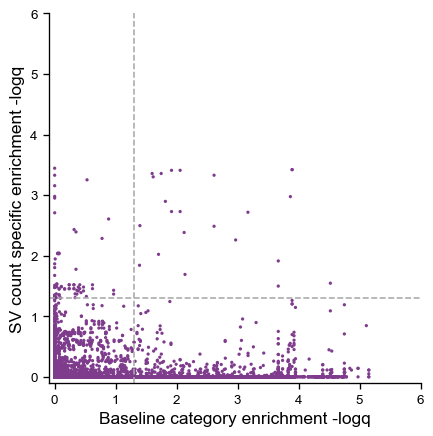

In [294]:
fig, ax = plt.subplots(1, figsize = (5, 5))

sns.scatterplot(x = -np.log10(stringent_noncoding_results['category_baseline_fdr_p']), y = -np.log10(stringent_noncoding_results['fdr_p_cases_unique']),
                ax = ax, s = 6, ec = None)

ax.set_xlim([-0.1, 6])
ax.set_ylim([-0.1, 6])
ax.set_xlabel('Baseline category enrichment -logq')
ax.set_ylabel('SV count specific enrichment -logq')
ax.axvline(x = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')
ax.axhline(y = -np.log10(0.05), color = 'darkgrey', linestyle = 'dashed')

sns.despine()

fig.savefig('images/separating-influences-cwas-gene-set-enrichment-noncoding.png', bbox_inches = 'tight')

In [318]:
test = stringent_noncoding_results.query('category_baseline_fdr_p < 0.05 & fdr_p_cases_unique < 1 & fdr_p_cases_unique > 0.05')
test_counts = test.groupby(['functional_category', 'db', 'gs']).size().reset_index()
print(test.drop_duplicates(subset = ['category'])['functional_category'].value_counts())
# test.sort_values(by = 0, ascending = False).head(10)


neuroblastoma_tad_boundary         8
neuroblastoma_atac_peaks           6
neuroblastoma_chromHMM15_EnhBiv    3
neuroblastoma_chromHMM15_Enh       2
neuroblastoma_H3K27Ac_peak         2
neuroblastoma_chromHMM15_EnhG      1
recombination_hotspot              1
Name: functional_category, dtype: int64


In [343]:
neuroblastoma_tad = test[(test['functional_category'] == "neuroblastoma_tad_boundary") & (test['db'] != 'Reactome_2022')]

In [347]:
for index, row in neuroblastoma_tad.iterrows():
    print(row['category'], row['gs'])

ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding Estrogen Response Late
DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding anterograde axonal transport (GO:0008089)
DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding IL-2/STAT5 Signaling
ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding anterograde axonal transport (GO:0008089)
ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding anterograde synaptic vesicle transport (GO:0048490)
DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding Estrogen Response Late
DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding IL-2/STAT5 Signaling
ANY.SINGLETON.ANY.neuroblas

In [354]:
test2 = stringent_noncoding_results.query('fdr_p_cases_unique < 0.05')
test2_counts = test2.groupby(['functional_category', 'db', 'gs']).size().reset_index()
print(test2.drop_duplicates(subset = ['category'])['functional_category'].value_counts())
# test.sort_values(by = 0, ascending = False).head(10)


neuroblastoma_tad_boundary         4
neuroblastoma_atac_peaks           4
neuroblastoma_H3K27Ac_peak         2
neuroblastoma_chromHMM15_EnhBiv    2
neuroblastoma_chromHMM15_Enh       1
Name: functional_category, dtype: int64


In [362]:
test2[test2['functional_category'] == "neuroblastoma_chromHMM15_Enh"]

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category,category_baseline_fdr_p
3139579,ANY.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,non-coding,single,category_subset,GO_Biological_Process_Specific,cellular response to cocaine (GO:0071314),4,8/15043,5/349,53.49564,0.0,0.00434,1,8/15043,2/2097,1.84576,0.34491,1.00000,3,8/13680,4/188,58.68261,0.0,0.04551,ANY,neuroblastoma_chromHMM15_Enh,1.0
3189811,ANY.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh...,non-coding,single,category_subset,GO_Biological_Process_Full,cellular response to cocaine (GO:0071314),4,8/15043,5/349,53.49564,0.0,0.00343,1,8/15043,2/2097,1.84576,0.34491,0.88545,3,8/13680,4/188,58.68261,0.0,0.01574,ANY,neuroblastoma_chromHMM15_Enh,1.0


In [372]:
print(sorted(gene_sets['MSigDB_Hallmark_2020 | Estrogen Response Late']))

['ABCA3', 'ABHD2', 'ACOX2', 'ADD3', 'AFF1', 'AGR2', 'ALDH3A2', 'ALDH3B1', 'AMFR', 'ANXA9', 'AREG', 'ARL3', 'ASCL1', 'ASS1', 'ATP2B4', 'BAG1', 'BATF', 'BCL2', 'BLVRB', 'BTG3', 'CA12', 'CA2', 'CACNA2D2', 'CALCR', 'CAV1', 'CCN5', 'CCNA1', 'CCND1', 'CD44', 'CD9', 'CDC20', 'CDC6', 'CDH1', 'CELSR2', 'CHPT1', 'CHST8', 'CISH', 'CKB', 'CLIC3', 'COX6C', 'CPE', 'CXCL12', 'CXCL14', 'CYP26B1', 'CYP4F11', 'DCXR', 'DHCR7', 'DHRS2', 'DLG5', 'DNAJC1', 'DNAJC12', 'DUSP2', 'DYNLT3', 'EGR3', 'ELOVL5', 'EMP2', 'ETFB', 'FABP5', 'FARP1', 'FDFT1', 'FGFR3', 'FKBP4', 'FKBP5', 'FLNB', 'FOS', 'FOXC1', 'FRK', 'GAL', 'GALE', 'GINS2', 'GJB3', 'GLA', 'GPER1', 'HMGCS2', 'HOMER2', 'HPRT1', 'HR', 'HSPA4L', 'HSPB8', 'ID2', 'IDH2', 'IGFBP4', 'IGSF1', 'IL17RB', 'IL6ST', 'IMPA2', 'ISG20', 'ITPK1', 'JAK1', 'JAK2', 'KCNK5', 'KIF20A', 'KLF4', 'KLK10', 'KLK11', 'KRT13', 'KRT19', 'LAMC2', 'LARGE1', 'LLGL2', 'LSR', 'LTF', 'MAPK13', 'MAPT', 'MDK', 'MEST', 'METTL3', 'MICB', 'MOCS2', 'MYB', 'MYOF', 'NAB2', 'NBL1', 'NCOR2', 'NMU', 'N

In [ ]:
test_cat = "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding"
category_sv_gse_gene_lists.query(f'category == "{test_cat}" & cohort == "cases-unique" & sv_incl_strat == "single"')

<AxesSubplot:xlabel='log-odds', ylabel='-logq'>

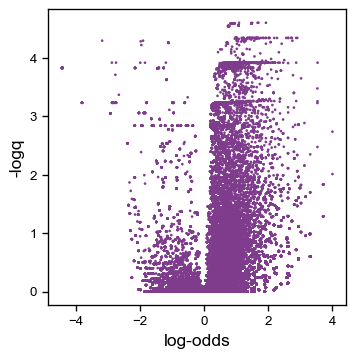

In [380]:
test3 = category_baseline_gse_results[category_baseline_gse_results['category'].str.contains('\.neuroblastoma_tad_boundary\.')]
sns.scatterplot(x = 'log-odds', y = '-logq', data = test3, s = 4, ec = None)

In [384]:
stringent_noncoding_neurogenesis = joint_data[(joint_data['sv_incl_strat'] == "single") &
                                      (joint_data['gene_subset'] == "none") &
                                      (joint_data['unique_gene_overlaps_cases_unique'] > 1) &
                                      (joint_data['p_controls'] > 0.05) &
                                      (joint_data['sv_category'] == "non-coding") & 
                                             (joint_data['gs'] == "neurogenesis (GO:0022008)")]

In [385]:
stringent_noncoding_neurogenesis

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category,category_baseline_fdr_p
1287890,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),20,1322/19092,20/201,1.49324,0.09311,1.00000,55,1322/19092,70/960,1.05904,0.64806,1.00000,12,1275/18396,12/130,1.36938,0.29580,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1503754,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),21,1322/19092,21/218,1.44052,0.13739,1.00000,69,1322/19092,84/1059,1.16476,0.19169,1.00000,12,1262/18266,12/142,1.24645,0.40876,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1611686,DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),19,1322/19092,19/217,1.29475,0.28059,1.00000,71,1322/19092,87/1085,1.17947,0.15720,0.95911,12,1258/18249,12/142,1.24956,0.40771,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1719618,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.P...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),20,1322/19092,20/212,1.40721,0.17096,1.00000,61,1322/19092,79/1062,1.08434,0.49414,1.00000,12,1269/18353,12/129,1.38490,0.29234,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1827550,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),7,1322/19092,7/81,1.27311,0.50769,1.00000,16,1322/19092,19/325,0.83267,0.50860,1.00000,3,1310/18848,3/53,0.80291,1.00000,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
1935482,DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.P...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),7,1322/19092,7/85,1.20761,0.66518,1.00000,18,1322/19092,23/350,0.94382,0.91527,1.00000,3,1308/18832,3/55,0.77255,1.00000,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
2043414,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),10,1322/19092,10/117,1.25841,0.46299,1.00000,29,1322/19092,39/524,1.08156,0.60155,1.00000,4,1299/18728,4/73,0.77726,0.81794,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
2151346,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),11,1322/19092,11/128,1.26611,0.48139,1.00000,39,1322/19092,45/575,1.14646,0.40350,1.00000,5,1289/18653,5/82,0.87435,1.00000,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
2259278,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),12,1322/19092,12/125,1.43160,0.21710,1.00000,32,1322/19092,39/586,0.95600,0.86877,1.00000,8,1294/18624,8/87,1.35858,0.39414,1.0,ANY,neuroblastoma_tad_boundary,0.001439
2367210,DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,non-coding,single,none,GO_Biological_Process_Full,neurogenesis (GO:0022008),11,1322/19092,11/126,1.28835,0.37957,1.00000,40,1322/19092,47/584,1.18252,0.28139,1.00000,6,1287/18649,6/80,1.09444,0.82331,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316


In [383]:
stringent_noncoding_results.query('gs == "neurogenesis (GO:0022008)"')

,category,sv_category,sv_incl_strat,gene_subset,db,gs,unique_gene_overlaps_cases,expected_cases,data_cases,odds_ratio_cases,p_cases,fdr_p_cases,unique_gene_overlaps_controls,expected_controls,data_controls,odds_ratio_controls,p_controls,fdr_p_controls,unique_gene_overlaps_cases_unique,expected_cases_unique,data_cases_unique,odds_ratio_cases_unique,p_cases_unique,fdr_p_cases_unique,expression,functional_category,category_baseline_fdr_p
1179959,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),35,540/5936,35/313,1.27944,0.18825,1.0,105,540/5936,140/1616,0.92867,0.48330,1.00000,20,450/4819,20/182,1.21016,0.43449,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1287891,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),20,540/5936,20/181,1.25203,0.35665,1.0,52,540/5936,67/843,0.84659,0.24495,0.99320,12,496/5337,12/115,1.14146,0.62624,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1395823,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),35,540/5936,35/327,1.21596,0.27664,1.0,114,540/5936,155/1731,0.97242,0.80687,1.00000,20,441/4775,20/181,1.23427,0.36020,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1503755,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),21,540/5936,21/205,1.14790,0.53625,1.0,68,540/5936,83/981,0.90763,0.46759,1.00000,12,481/5180,12/129,1.00312,1.00000,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1611687,DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),19,540/5936,19/205,1.02327,0.90150,1.0,70,540/5936,86/1004,0.92147,0.54867,1.00000,12,477/5165,12/130,1.00077,1.00000,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1719619,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.P...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),20,540/5936,20/191,1.17769,0.52092,1.0,57,540/5936,75/933,0.85910,0.26488,0.99749,12,491/5302,12/114,1.15805,0.62288,1.0,ANY,neuroblastoma_tad_boundary,0.001439
1827551,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),7,287/3309,7/77,1.05500,0.83748,1.0,15,287/3309,18/292,0.67481,0.12692,0.92758,3,276/3094,3/49,0.66269,0.79828,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
1935483,DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.P...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),7,287/3309,7/81,0.99696,1.00000,1.0,17,287/3309,22/315,0.77310,0.29375,1.00000,3,274/3080,3/51,0.63676,0.62068,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
2043415,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),10,287/3309,10/107,1.08973,0.72796,1.0,26,287/3309,36/470,0.85428,0.42824,1.00000,4,267/2990,4/66,0.65350,0.51680,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316
2151347,DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,non-coding,single,category_subset,GO_Biological_Process_Full,neurogenesis (GO:0022008),11,287/3309,11/123,1.03623,0.87025,1.0,38,287/3309,44/539,0.93066,0.73813,1.00000,5,255/2902,5/77,0.71583,0.68127,1.0,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,0.001316


What about with no subsetting

In [321]:
stringent_noncoding_results_none = joint_data[(joint_data['sv_incl_strat'] == "single") &
                                      (joint_data['gene_subset'] == "none") &
                                      (joint_data['unique_gene_overlaps_cases_unique'] > 1) &
                                      (joint_data['p_controls'] > 0.05) &
                                      (joint_data['sv_category'] == "non-coding")]

<AxesSubplot:xlabel='odds_ratio_cases_unique', ylabel='fdr_p_cases_unique'>

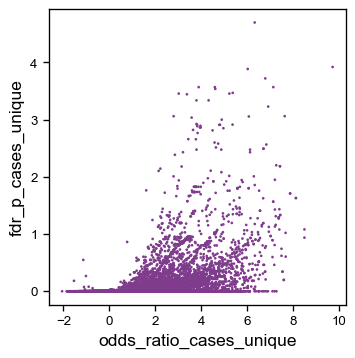

In [324]:
sns.scatterplot(x = np.log2(stringent_noncoding_results_none['odds_ratio_cases_unique']), 
                y = -np.log10(stringent_noncoding_results_none['fdr_p_cases_unique']), ec = None, s = 4)

In [331]:
stringent_noncoding_results_none.query('db == "MSigDB_Hallmark_2020" & fdr_p_cases_unique < 0.05')['gs'].value_counts()

UV Response Dn                   3
G2-M Checkpoint                  2
E2F Targets                      2
Myc Targets V1                   2
Myc Targets V2                   2
heme Metabolism                  2
TNF-alpha Signaling via NF-kB    1
Allograft Rejection              1
Protein Secretion                1
Name: gs, dtype: int64

In [332]:
stringent_noncoding_results_none.query('db == "GO_Biological_Process_Full" & fdr_p_cases_unique < 0.05')['gs'].value_counts()

negative regulation of cell-matrix adhesion (GO:0001953)                         4
tube development (GO:0035295)                                                    3
respiratory system development (GO:0060541)                                      3
respiratory tube development (GO:0030323)                                        3
lung development (GO:0030324)                                                    3
maintenance of epithelial cell apical/basal polarity (GO:0045199)                2
calcium ion transmembrane import into cytosol (GO:0097553)                       2
quaternary ammonium group transport (GO:0015697)                                 2
synaptic vesicle coating (GO:0016183)                                            2
regulation of release of sequestered calcium ion into cytosol (GO:0051279)       2
supramolecular fiber organization (GO:0097435)                                   2
maintenance of cell polarity (GO:0030011)                                        2
tele

# Analyze high level results

We underwent numerous filtering steps to try to distill things down to reliable results. We have a high index of suspicion for ANY significant result, but let's at least see:

Let's start by examining the most "stringent" criteria. `single` for `sv_incl_strat`, significant in unique cases, non-significant in controls, and at least two genes overlapping with the gene set.

In [169]:
coding_stringent_results = gse_results[(gse_results['sv_category'] == 'coding') &
                                       (gse_results['sv_incl_strat'] == 'single') &
                                       (gse_results['p_controls'] > 0.05) &
                                       (gse_results['num_unique_gene_overlaps_cases_unique'] > 1)].copy()

coding_stringent_results['-logq'] = -np.log10(coding_stringent_results['q_cases_unique'])
coding_stringent_results['log-odds'] = np.log(coding_stringent_results['res_cases_unique'])

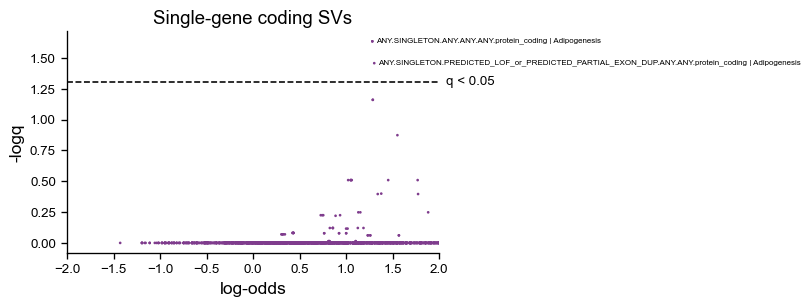

In [170]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = coding_stringent_results,
                ec = None, s = 4)
ax.set_xlim([-2, 2])
ax.set_title('Single-gene coding SVs')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 1.02, y = 0.76, s = 'q < 0.05', transform = ax.transAxes, fontsize = 10)

for index, row in coding_stringent_results.query('q_cases_unique < 0.05').iterrows():
    if 'UMBRELLA' in row['category']: 
        continue
    
    x = row['log-odds']
    y = row['-logq']
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.04, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-coding-svs-gene-set-enrichment-plot.png', bbox_inches = 'tight')

So there's a lot of fatty acid metabolism here. I have no real clue what this means, but there is precedence for fatty acid metabolism being relevant in NBL: https://pubmed.ncbi.nlm.nih.gov/35531888/

In [168]:
noncoding_stringent_results = gse_results[(gse_results['sv_category'] == 'non-coding') &
                                          (gse_results['sv_incl_strat'] == 'single') &
                                          (gse_results['p_controls'] > 0.05) &
                                          (gse_results['num_unique_gene_overlaps_cases_unique'] > 1)].copy()

noncoding_stringent_results['-logq'] = -np.log10(noncoding_stringent_results['q_cases_unique'])
noncoding_stringent_results['log-odds'] = np.log(noncoding_stringent_results['res_cases_unique'])

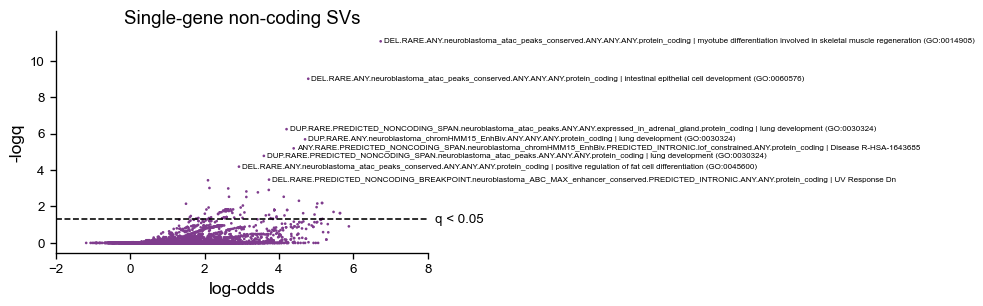

In [189]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = noncoding_stringent_results,
                ec = None, s = 4)
ax.set_xlim([-2, 8])
ax.set_title('Single-gene non-coding SVs')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 8.2, y = -np.log10(0.05), s = 'q < 0.05', fontsize = 10, va = 'center')

for i, (index, row) in enumerate(noncoding_stringent_results.query('q_cases_unique < 0.05').sort_values(by = '-logq', ascending = False).iterrows()):
    
    if i > 7:
        continue
    
    x = row['log-odds']
    y = row['-logq']
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.08, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-non-coding-svs-gene-set-enrichment-plot.png', bbox_inches = 'tight')

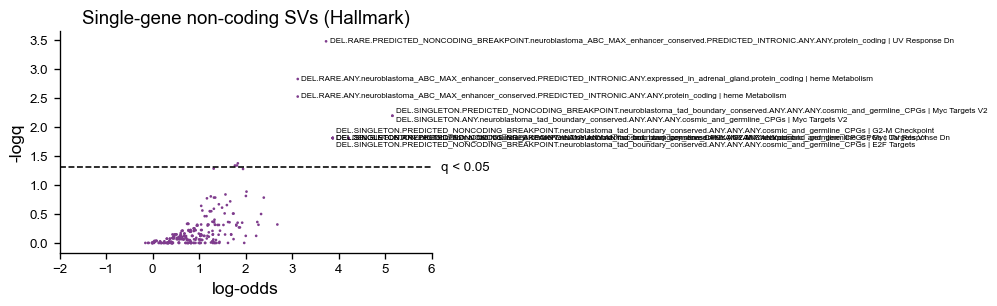

In [207]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = noncoding_stringent_results.query('db == "MSigDB_Hallmark_2020"'),
                ec = None, s = 4)
ax.set_xlim([-2, 6])
ax.set_title('Single-gene non-coding SVs (Hallmark)')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 6.2, y = -np.log10(0.05), s = 'q < 0.05', fontsize = 10, va = 'center')

for i, (index, row) in enumerate(noncoding_stringent_results.query('q_cases_unique < 0.05 & db == "MSigDB_Hallmark_2020"').sort_values(by = '-logq', ascending = False).iterrows()):
    
    if i > 9:
        continue
    
    x = row['log-odds']
    y = row['-logq']
    
    if i == 3:
        y += 0.08
    if i == 4:
        y += -0.08
        
    if i == 5:
        y += 0.12
    if i == 6:
        y += -0.12
        
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.08, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-non-coding-svs-gene-set-enrichment-plot-hallmark.png', bbox_inches = 'tight')

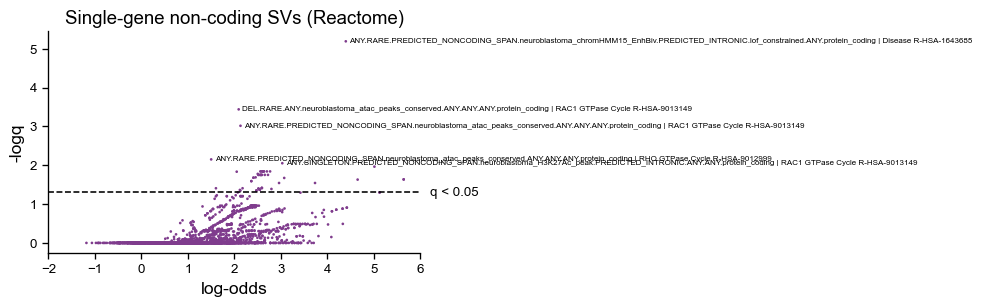

In [212]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = noncoding_stringent_results.query('db == "Reactome_2022"'),
                ec = None, s = 4)
ax.set_xlim([-2, 6])
ax.set_title('Single-gene non-coding SVs (Reactome)')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 6.2, y = -np.log10(0.05), s = 'q < 0.05', fontsize = 10, va = 'center')

for i, (index, row) in enumerate(noncoding_stringent_results.query('q_cases_unique < 0.05 & db == "Reactome_2022"').sort_values(by = '-logq', ascending = False).iterrows()):
    
    if i > 4:
        continue
    
    x = row['log-odds']
    y = row['-logq']
    
#     if i == 3:
#         y += 0.08
#     if i == 4:
#         y += -0.08
        
#     if i == 5:
#         y += 0.12
#     if i == 6:
#         y += -0.12
        
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.08, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-non-coding-svs-gene-set-enrichment-plot-reactome.png', bbox_inches = 'tight')

In [213]:
noncoding_stringent_results.query('q_cases_unique < 0.05 & db == "Reactome_2022"').sort_values(by = '-logq', ascending = False)

,category,af_category,sv_category,category_p,sv_incl_strat,num_genes_cases,num_genes_controls,db,gs,expected,res_cases,p_cases,num_unique_gene_overlaps_cases,data_cases,res_controls,p_controls,num_unique_gene_overlaps_controls,data_controls,expected_unique,res_cases_unique,p_cases_unique,num_unique_gene_overlaps_cases_unique,data_cases_unique,q_cases_unique,-logq,log-odds
1428526,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,rare,non-coding,0.000019,single,7,15,Reactome_2022,Disease R-HSA-1643685,1724/19201,10.150407,0.000028,2,8/16,0.000000,0.167754,0,0/27,1724/19186,81.133566,3.552992e-08,2,8/9,0.000006,5.190290,4.396097
1371611,DEL.RARE.ANY.neuroblastoma_atac_peaks_conserve...,rare,non-coding,0.000009,single,488,1549,Reactome_2022,RAC1 GTPase Cycle R-HSA-9013149,177/19201,1.674261,0.088346,9,12/824,0.976148,1.000000,25,39/5046,152/17652,8.105556,4.012717e-07,8,11/176,0.000364,3.438476,2.092550
1833211,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,rare,non-coding,0.000140,single,399,1313,Reactome_2022,RAC1 GTPase Cycle R-HSA-9013149,177/19201,1.668362,0.142540,7,10/681,0.655133,0.065434,17,23/4201,160/17890,8.426988,3.185933e-06,6,9/132,0.000964,3.015799,2.131439
1833221,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,rare,non-coding,0.000140,single,399,1313,Reactome_2022,RHO GTPase Cycle R-HSA-9012999,440/19201,1.471322,0.086539,14,22/681,1.034282,0.765784,42,90/4201,398/17890,4.487179,4.041480e-05,8,12/132,0.007074,2.150314,1.501224
938861,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,singleton,non-coding,0.000175,single,37,135,Reactome_2022,RAC1 GTPase Cycle R-HSA-9013149,177/19201,16.269665,0.000028,5,5/39,2.262426,0.154162,3,3/148,174/19066,20.706772,9.777874e-06,5,5/32,0.008878,2.051670,3.030461
1313286,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,singleton,non-coding,0.000309,single,148,731,Reactome_2022,Formation Of Xylulose-5-Phosphate R-HSA-5661270,5/19201,128.845638,0.000009,2,3/152,0.000000,1.000000,0,0/807,5/18471,150.146341,5.984053e-06,2,3/126,0.010867,1.963889,5.011610
735917,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,CDK-mediated Phosphorylation And Removal Of Cd...,72/19201,7.523199,0.000786,4,5/192,1.124346,0.782542,4,4/1005,68/18434,13.933556,5.103438e-05,4,5/108,0.014424,1.840927,2.634300
735741,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,APC/C:Cdc20 Mediated Degradation Of Securin R-...,67/19201,8.122400,0.000568,4,5/192,0.895256,1.000000,3,3/1005,64/18434,14.865696,3.820720e-05,4,5/108,0.014424,1.840927,2.699056
735971,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,Cellular Response To Hypoxia R-HSA-1234174,73/19201,7.413780,0.000837,4,5/192,1.406838,0.413333,5,5/1005,68/18434,13.933556,5.103438e-05,4,5/108,0.014424,1.840927,2.634300
735956,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,Cdc20:Phospho-APC/C Mediated Degradation Of Cy...,72/19201,7.523199,0.000786,4,5/192,0.830166,1.000000,3,3/1005,69/18434,13.718447,5.470710e-05,4,5/108,0.014424,1.840927,2.618741


So some estrogen-related metabolism. Again, there is precedence for the intersection between estrogen metabolism and neuroblastoma:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5819392/

But searching for targeted results here is biased--there will always be associations.

# Dig deeper into specific "hits"

I'd like to dig deeper into specific results here. We'll look at pure overlaps.

In [43]:
coding_stringent_results = gse_results.query('sv_category == "coding" & sv_incl_strat == "single" & p_cases_unique < 0.05 & p_controls > 0.05 & num_unique_gene_overlaps_cases_unique > 1')


It looks like `Adipogenesis` is the result that predominantly arises. Let's take a closer look.

In [50]:
adipogenesis = coding_stringent_results.query('gs == "Adipogenesis"')
test_sig = adipogenesis.iloc[0]

In [51]:
test_sig

category                                 ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
af_category                                                                      singleton
sv_category                                                                         coding
category_p                                                                             0.0
sv_incl_strat                                                                       single
num_genes_cases                                                                        354
num_genes_controls                                                                    1855
db                                                                    MSigDB_Hallmark_2020
gs                                                                            Adipogenesis
expected                                                                         200/19201
res_cases                                                                         3.253669

In [54]:
test_cat

'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding'

In [64]:
test_cat = test_sig.loc['category']
unique_case_genes = result_gene_lists.query(f'sv_incl_strat == "single" & category == "{test_cat}" & cohort == "case-unique"')
print(unique_case_genes['count'].sum())

# what genes overlap with adipogenesis?
unique_case_genes[unique_case_genes['gene'].isin(gene_sets['MSigDB_Hallmark_2020']['Adipogenesis'])]

278


,gene,count,cohort,sv_incl_strat,category
5874,ACADM,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5956,GPAM,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5976,ITSN1,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5984,LAMA4,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5989,LPL,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6002,MTARC2,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6051,RETN,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6075,SLC66A3,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6081,SQOR,2,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...


That's 9 unique genes, which is a fair bit for only 278 genes. Several of these genes are _core_ adipogenesis genes (makes sense, given that it's Hallmark gene sets). Interestingly, we see a double hit in `SQOR`. These are `singleton` genes, so this is truly two independent SVs, which is neat.

In [8]:
columns = ['name', 'gene', 'mean_exp', 'num_greater_0_dosage', 'mean_greater_0_dosage_rank', 'mean_greater_0_exp', 'mean_leq_0_exp', 
           'mwu_p', 'ordinal_p', 'ordinal_coef']

In [24]:
test = []
for file in ['out1.txt', 'out2.txt', 'out3.txt']:
    test.append(pd.read_csv(file, sep='\t', names = columns))
    
test = pd.concat(test)

In [26]:
test.drop_duplicates(subset = ['name', 'gene'])

,name,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
0,PedSV.2.5.2_CNV_chr1_6,OR4F29,0.266629,15,0.507955,0.247333,0.270541,0.912668,0.582179,-0.188116
1,PedSV.2.5.2_CNV_chr1_7,OR4F29,0.266629,62,0.510264,0.255484,0.292222,0.620135,0.461080,-0.181469
2,PedSV.2.5.2_CNV_chr1_8,OR4F29,0.266629,7,0.669643,0.128571,0.278415,0.112705,0.285824,-0.469457
3,PedSV.2.5.2_CNV_chr1_9,OR4F16,0.266629,6,0.467803,0.275000,0.266024,0.787030,0.059611,0.692249
4,PedSV.2.5.2_DEL_chr1_14,OR4F16,0.266629,1,0.181818,0.410000,0.265000,0.284093,0.289008,1.528343
...,...,...,...,...,...,...,...,...,...,...
25178,PedSV.2.5.2_DEL_chrX_9199,TMLHE,6.893294,1,0.666667,4.960000,6.916310,0.582156,0.624238,-0.702048
25179,PedSV.2.5.2_DEL_chrX_9201,TMLHE,6.893294,1,0.666667,4.960000,6.916310,0.582156,0.624238,-0.702048
25180,PedSV.2.5.2_DEL_chrX_9209,TMLHE,6.818427,4,0.607955,5.382500,6.886000,0.457704,0.516950,-0.485093
25181,PedSV.2.5.2_INS_chrX_2887,TMLHE,6.818427,68,0.528242,6.523971,7.771905,0.103474,0.245370,-0.439022


In [218]:
test = pd.read_csv('/Users/jettcrowdis/Dropbox (Personal)/Mac/Downloads/ENCFF994UIF.bed', sep='\t', header = None)

In [220]:
test[4].sum()

167323371